In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from matplotlib import pyplot as plt
from data.dataloader import synthetic_dataset
from torch.utils.data import DataLoader
from model import Model

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')


Bad key "text.kerning_factor" on line 4 in
c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [20]:
def set_random_seed(seed):
    torch.random.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic=True

set_random_seed(1)

In [21]:
device = 'cuda:0'

# Some settings related to the synthetic data
nr_classes = 3         # The number of classes in the data
nr_channels = 2        # The number of channels of the data
window_length = 3000   # The number of samples per labelled window
k = 1                  # The number of mini-windows to select per window
nr_iters = 500         # The number of iterations to train the model

settings = {
'hypernet_settings':{'input_dim':[nr_channels,window_length],  
                    'output_channels':[8,16,32,64], 
                    'kernel_sizes':[15,9,5,3], 
                    'poolings':[5,5,3],  #The last layer has no pooling, so no pooling factor needs to be set.
                    'gumbel_softmax_temperature':{'start':10.0, 'end':0.5, 'nr_iters':nr_iters//2}, # nr_iters is the nr of iterations in which the temperature decays from start to end value.
                    'k': k, 
                    'mini_window_temporal_reduction_factor': 6, #the factor with which mini-windows are smaller in the temporal dimension that the full windows of length window_length
                    }, 
'encoder_settings':{
                    'output_channels':[8,16,32,64],
                    'kernel_sizes':[15,9,5,3], 
                    'poolings':[5,5,3]}, #The last layer is a adaptive average pooling, so no pooling factor needs to be set.
'sampling_type': 'active', #  Choose from: {'active', 'random'}
'nr_classes':nr_classes
}


### Train a model

Iteration 1/500, Loss: 1.0968859195709229 - Val. loss: 1.0963412523269653
Stored a new best model at iteration 1.
Iteration 2/500, Loss: 1.089991807937622 - Val. loss: 1.0512199401855469
Stored a new best model at iteration 2.
Iteration 3/500, Loss: 0.82215416431427 - Val. loss: 2.2824740409851074
Iteration 4/500, Loss: 0.5760176181793213 - Val. loss: 5.132124900817871
Iteration 5/500, Loss: 0.4912636876106262 - Val. loss: 8.195584297180176
Iteration 6/500, Loss: 0.4453393518924713 - Val. loss: 10.6668701171875
Iteration 7/500, Loss: 0.41155675053596497 - Val. loss: 12.119254112243652
Iteration 8/500, Loss: 0.38004568219184875 - Val. loss: 13.611529350280762
Iteration 9/500, Loss: 0.3678886294364929 - Val. loss: 12.951510429382324
Iteration 10/500, Loss: 0.36334919929504395 - Val. loss: 10.977496147155762
Iteration 11/500, Loss: 0.3346671164035797 - Val. loss: 9.783275604248047
Iteration 12/500, Loss: 0.32364317774772644 - Val. loss: 8.737152099609375
Iteration 13/500, Loss: 0.30536603

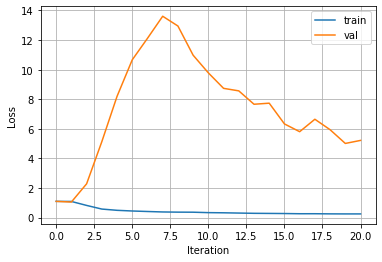

Iteration 22/500, Loss: 0.23903214931488037 - Val. loss: 4.909101963043213
Iteration 23/500, Loss: 0.2344231903553009 - Val. loss: 4.321601390838623
Iteration 24/500, Loss: 0.2301386594772339 - Val. loss: 3.9444656372070312
Iteration 25/500, Loss: 0.22383074462413788 - Val. loss: 4.432773590087891
Iteration 26/500, Loss: 0.22550354897975922 - Val. loss: 3.602656602859497
Iteration 27/500, Loss: 0.2205294370651245 - Val. loss: 3.84421968460083
Iteration 28/500, Loss: 0.2175973355770111 - Val. loss: 3.1615121364593506
Iteration 29/500, Loss: 0.21346436440944672 - Val. loss: 3.771440029144287
Iteration 30/500, Loss: 0.21318164467811584 - Val. loss: 2.658576250076294
Iteration 31/500, Loss: 0.2097570151090622 - Val. loss: 3.1508567333221436
Iteration 32/500, Loss: 0.21023699641227722 - Val. loss: 3.150587797164917
Iteration 33/500, Loss: 0.2046971172094345 - Val. loss: 2.553373336791992
Iteration 34/500, Loss: 0.19935303926467896 - Val. loss: 3.1754956245422363
Iteration 35/500, Loss: 0.19

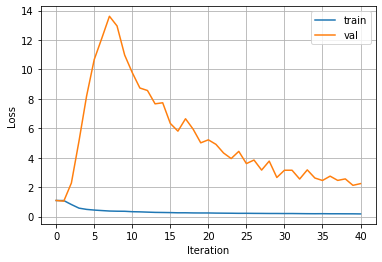

Iteration 42/500, Loss: 0.1836714744567871 - Val. loss: 2.1062378883361816
Iteration 43/500, Loss: 0.18739181756973267 - Val. loss: 2.397688865661621
Iteration 44/500, Loss: 0.18102742731571198 - Val. loss: 2.2514491081237793
Iteration 45/500, Loss: 0.1814264953136444 - Val. loss: 2.3344967365264893
Iteration 46/500, Loss: 0.17583979666233063 - Val. loss: 2.3397679328918457
Iteration 47/500, Loss: 0.17304635047912598 - Val. loss: 2.2964253425598145
Iteration 48/500, Loss: 0.17119614779949188 - Val. loss: 2.5047593116760254
Iteration 49/500, Loss: 0.17182621359825134 - Val. loss: 2.2549493312835693
Iteration 50/500, Loss: 0.17102515697479248 - Val. loss: 2.2855443954467773
Iteration 51/500, Loss: 0.1684383898973465 - Val. loss: 2.3873727321624756
Iteration 52/500, Loss: 0.16496801376342773 - Val. loss: 2.3426854610443115
Iteration 53/500, Loss: 0.16702944040298462 - Val. loss: 2.4731128215789795
Iteration 54/500, Loss: 0.16799482703208923 - Val. loss: 2.1174156665802
Iteration 55/500, L

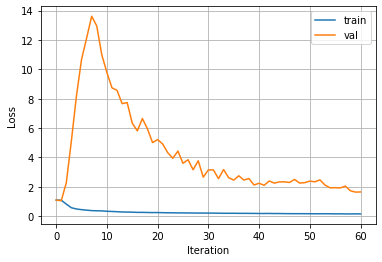

Iteration 62/500, Loss: 0.15345889329910278 - Val. loss: 1.4516468048095703
Iteration 63/500, Loss: 0.15469323098659515 - Val. loss: 1.4490866661071777
Iteration 64/500, Loss: 0.15448544919490814 - Val. loss: 1.5013891458511353
Iteration 65/500, Loss: 0.15669065713882446 - Val. loss: 1.2608596086502075
Iteration 66/500, Loss: 0.15518949925899506 - Val. loss: 1.2012418508529663
Iteration 67/500, Loss: 0.15526969730854034 - Val. loss: 1.1940619945526123
Iteration 68/500, Loss: 0.16062934696674347 - Val. loss: 0.9410661458969116
Stored a new best model at iteration 68.
Iteration 69/500, Loss: 0.16332729160785675 - Val. loss: 0.8307501673698425
Stored a new best model at iteration 69.
Iteration 70/500, Loss: 0.17350450158119202 - Val. loss: 0.8974028825759888
Iteration 71/500, Loss: 0.3389136791229248 - Val. loss: 2.084109306335449
Iteration 72/500, Loss: 0.23817871510982513 - Val. loss: 2.4077935218811035
Iteration 73/500, Loss: 0.2226414680480957 - Val. loss: 2.397946357727051
Iteration 

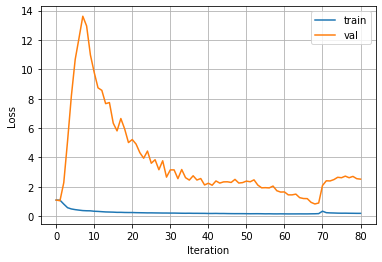

Iteration 82/500, Loss: 0.18924270570278168 - Val. loss: 2.527203321456909
Iteration 83/500, Loss: 0.1878146380186081 - Val. loss: 2.7239227294921875
Iteration 84/500, Loss: 0.18378368020057678 - Val. loss: 2.8226823806762695
Iteration 85/500, Loss: 0.18639707565307617 - Val. loss: 2.4041168689727783
Iteration 86/500, Loss: 0.1827554702758789 - Val. loss: 3.006927490234375
Iteration 87/500, Loss: 0.18254056572914124 - Val. loss: 2.721787452697754
Iteration 88/500, Loss: 0.18230322003364563 - Val. loss: 2.676642417907715
Iteration 89/500, Loss: 0.17883838713169098 - Val. loss: 2.823110818862915
Iteration 90/500, Loss: 0.18360327184200287 - Val. loss: 2.6554391384124756
Iteration 91/500, Loss: 0.17880657315254211 - Val. loss: 2.6658082008361816
Iteration 92/500, Loss: 0.17965003848075867 - Val. loss: 2.5933520793914795
Iteration 93/500, Loss: 0.17823874950408936 - Val. loss: 2.4218127727508545
Iteration 94/500, Loss: 0.17715005576610565 - Val. loss: 2.6455674171447754
Iteration 95/500, L

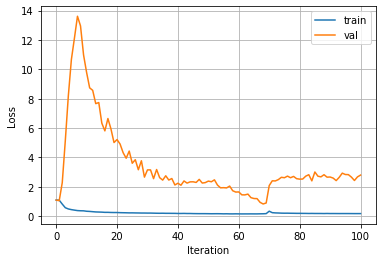

Iteration 102/500, Loss: 0.1780327707529068 - Val. loss: 2.7472972869873047
Iteration 103/500, Loss: 0.17629146575927734 - Val. loss: 2.552868127822876
Iteration 104/500, Loss: 0.17643526196479797 - Val. loss: 2.81402850151062
Iteration 105/500, Loss: 0.17146684229373932 - Val. loss: 2.681312322616577
Iteration 106/500, Loss: 0.17101457715034485 - Val. loss: 2.778423309326172
Iteration 107/500, Loss: 0.17573586106300354 - Val. loss: 2.6281051635742188
Iteration 108/500, Loss: 0.1722715049982071 - Val. loss: 2.5499989986419678
Iteration 109/500, Loss: 0.17299559712409973 - Val. loss: 2.556535482406616
Iteration 110/500, Loss: 0.17377659678459167 - Val. loss: 2.695394992828369
Iteration 111/500, Loss: 0.17366844415664673 - Val. loss: 2.232246160507202
Iteration 112/500, Loss: 0.1740642637014389 - Val. loss: 2.5813915729522705
Iteration 113/500, Loss: 0.17043589055538177 - Val. loss: 2.4488584995269775
Iteration 114/500, Loss: 0.1723233014345169 - Val. loss: 2.8319408893585205
Iteration 1

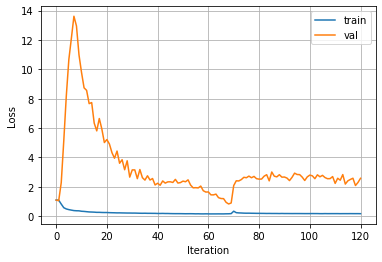

Iteration 122/500, Loss: 0.17134380340576172 - Val. loss: 2.298168659210205
Iteration 123/500, Loss: 0.1711776703596115 - Val. loss: 2.431292772293091
Iteration 124/500, Loss: 0.17171773314476013 - Val. loss: 2.664435386657715
Iteration 125/500, Loss: 0.17024897038936615 - Val. loss: 2.593407154083252
Iteration 126/500, Loss: 0.1718449741601944 - Val. loss: 2.530423402786255
Iteration 127/500, Loss: 0.1689499318599701 - Val. loss: 2.3697803020477295
Iteration 128/500, Loss: 0.17060565948486328 - Val. loss: 2.4768409729003906
Iteration 129/500, Loss: 0.17292430996894836 - Val. loss: 2.5921826362609863
Iteration 130/500, Loss: 0.17229050397872925 - Val. loss: 2.0721824169158936
Iteration 131/500, Loss: 0.1718016266822815 - Val. loss: 2.579770803451538
Iteration 132/500, Loss: 0.1728479117155075 - Val. loss: 2.3030624389648438
Iteration 133/500, Loss: 0.1708807647228241 - Val. loss: 2.4864869117736816
Iteration 134/500, Loss: 0.16874907910823822 - Val. loss: 2.398038864135742
Iteration 13

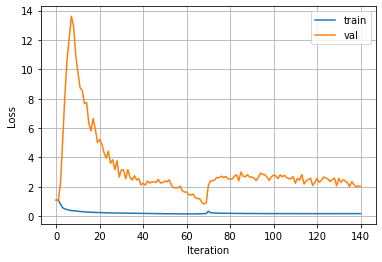

Iteration 142/500, Loss: 0.17243334650993347 - Val. loss: 2.1248042583465576
Iteration 143/500, Loss: 0.17468491196632385 - Val. loss: 2.0754501819610596
Iteration 144/500, Loss: 0.17540575563907623 - Val. loss: 1.9685039520263672
Iteration 145/500, Loss: 0.1733303964138031 - Val. loss: 2.2054452896118164
Iteration 146/500, Loss: 0.17352713644504547 - Val. loss: 1.9888776540756226
Iteration 147/500, Loss: 0.17724987864494324 - Val. loss: 2.0973989963531494
Iteration 148/500, Loss: 0.17593032121658325 - Val. loss: 2.0053985118865967
Iteration 149/500, Loss: 0.17710043489933014 - Val. loss: 1.8844813108444214
Iteration 150/500, Loss: 0.1766064167022705 - Val. loss: 1.799102783203125
Iteration 151/500, Loss: 0.1771790087223053 - Val. loss: 2.1196389198303223
Iteration 152/500, Loss: 0.17638136446475983 - Val. loss: 2.175766706466675
Iteration 153/500, Loss: 0.17779862880706787 - Val. loss: 1.9446172714233398
Iteration 154/500, Loss: 0.17825444042682648 - Val. loss: 1.792998194694519
Itera

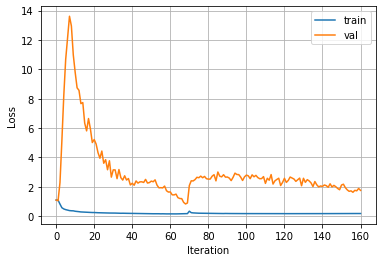

Iteration 162/500, Loss: 0.1756061613559723 - Val. loss: 1.8020284175872803
Iteration 163/500, Loss: 0.17919275164604187 - Val. loss: 1.8109722137451172
Iteration 164/500, Loss: 0.18115954101085663 - Val. loss: 1.964579463005066
Iteration 165/500, Loss: 0.1742790937423706 - Val. loss: 1.6795141696929932
Iteration 166/500, Loss: 0.17222094535827637 - Val. loss: 0.9710378646850586
Iteration 167/500, Loss: 0.17767688632011414 - Val. loss: 1.8124456405639648
Iteration 168/500, Loss: 0.17323608696460724 - Val. loss: 2.0168943405151367
Iteration 169/500, Loss: 0.17183151841163635 - Val. loss: 0.3746541440486908
Stored a new best model at iteration 169.
Iteration 170/500, Loss: 0.1729433536529541 - Val. loss: 0.22025202214717865
Stored a new best model at iteration 170.
Iteration 171/500, Loss: 0.17215974628925323 - Val. loss: 0.20966501533985138
Stored a new best model at iteration 171.
Iteration 172/500, Loss: 0.16931328177452087 - Val. loss: 0.18889938294887543
Stored a new best model at i

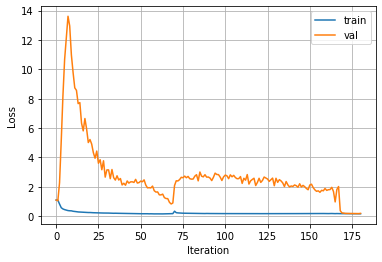

Iteration 182/500, Loss: 0.16872352361679077 - Val. loss: 0.1797863095998764
Iteration 183/500, Loss: 0.1576465517282486 - Val. loss: 0.17759257555007935
Iteration 184/500, Loss: 0.16050471365451813 - Val. loss: 0.17220041155815125
Iteration 185/500, Loss: 0.15709321200847626 - Val. loss: 0.16504234075546265
Stored a new best model at iteration 185.
Iteration 186/500, Loss: 0.16382147371768951 - Val. loss: 0.16783377528190613
Iteration 187/500, Loss: 0.16444022953510284 - Val. loss: 0.16954487562179565
Iteration 188/500, Loss: 0.15855838358402252 - Val. loss: 0.1639692187309265
Stored a new best model at iteration 188.
Iteration 189/500, Loss: 0.1537603884935379 - Val. loss: 0.16311639547348022
Stored a new best model at iteration 189.
Iteration 190/500, Loss: 0.1566866785287857 - Val. loss: 0.16458237171173096
Iteration 191/500, Loss: 0.15678207576274872 - Val. loss: 0.1650361716747284
Iteration 192/500, Loss: 0.16759468615055084 - Val. loss: 0.1728971004486084
Iteration 193/500, Loss

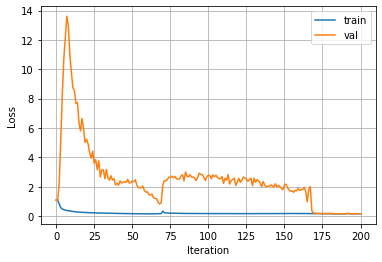

Iteration 202/500, Loss: 0.16931690275669098 - Val. loss: 0.17434927821159363
Iteration 203/500, Loss: 0.1608734428882599 - Val. loss: 0.15658846497535706
Iteration 204/500, Loss: 0.15832269191741943 - Val. loss: 0.1644737720489502
Iteration 205/500, Loss: 0.15686467289924622 - Val. loss: 0.16097089648246765
Iteration 206/500, Loss: 0.16440854966640472 - Val. loss: 0.1754351109266281
Iteration 207/500, Loss: 0.17716017365455627 - Val. loss: 0.1810365915298462
Iteration 208/500, Loss: 0.21956273913383484 - Val. loss: 0.25447601079940796
Iteration 209/500, Loss: 0.3180095851421356 - Val. loss: 0.49223294854164124
Iteration 210/500, Loss: 0.34107184410095215 - Val. loss: 0.5551397204399109
Iteration 211/500, Loss: 0.3269481658935547 - Val. loss: 0.47756269574165344
Iteration 212/500, Loss: 0.310856431722641 - Val. loss: 0.5286416411399841
Iteration 213/500, Loss: 0.30542153120040894 - Val. loss: 0.48949092626571655
Iteration 214/500, Loss: 0.30131953954696655 - Val. loss: 0.50538867712020

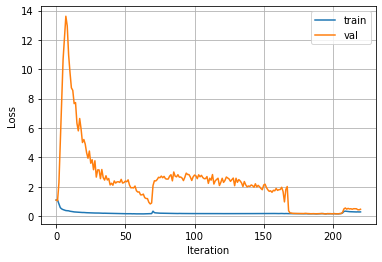

Iteration 222/500, Loss: 0.2826194167137146 - Val. loss: 0.49341490864753723
Iteration 223/500, Loss: 0.2846156656742096 - Val. loss: 0.4428110718727112
Iteration 224/500, Loss: 0.28275856375694275 - Val. loss: 0.49174198508262634
Iteration 225/500, Loss: 0.28700581192970276 - Val. loss: 0.42235472798347473
Iteration 226/500, Loss: 0.27983635663986206 - Val. loss: 0.4309074282646179
Iteration 227/500, Loss: 0.27392396330833435 - Val. loss: 0.44242578744888306
Iteration 228/500, Loss: 0.27826258540153503 - Val. loss: 0.39814522862434387
Iteration 229/500, Loss: 0.28156208992004395 - Val. loss: 0.3993344306945801
Iteration 230/500, Loss: 0.27392685413360596 - Val. loss: 0.40710678696632385
Iteration 231/500, Loss: 0.28111904859542847 - Val. loss: 0.4191182851791382
Iteration 232/500, Loss: 0.27962976694107056 - Val. loss: 0.379861980676651
Iteration 233/500, Loss: 0.271554559469223 - Val. loss: 0.4078224003314972
Iteration 234/500, Loss: 0.2759741246700287 - Val. loss: 0.3816680014133453

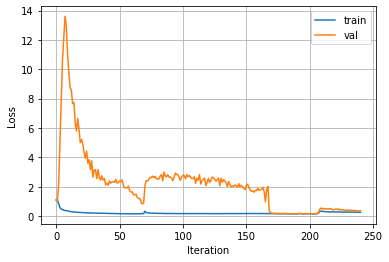

Iteration 242/500, Loss: 0.262362539768219 - Val. loss: 0.34506744146347046
Iteration 243/500, Loss: 0.26260659098625183 - Val. loss: 0.347356915473938
Iteration 244/500, Loss: 0.2609848082065582 - Val. loss: 0.33881324529647827
Iteration 245/500, Loss: 0.26338857412338257 - Val. loss: 0.34198883175849915
Iteration 246/500, Loss: 0.2568449079990387 - Val. loss: 0.3352956771850586
Iteration 247/500, Loss: 0.256570965051651 - Val. loss: 0.34526437520980835
Iteration 248/500, Loss: 0.2548205256462097 - Val. loss: 0.3420100808143616
Iteration 249/500, Loss: 0.25477334856987 - Val. loss: 0.33897289633750916
Iteration 250/500, Loss: 0.25623929500579834 - Val. loss: 0.3401756286621094


c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 251/500, Loss: 0.2573830187320709 - Val. loss: 0.3375062644481659
Iteration 252/500, Loss: 0.25599589943885803 - Val. loss: 0.33434948325157166
Iteration 253/500, Loss: 0.2506599426269531 - Val. loss: 0.33485400676727295
Iteration 254/500, Loss: 0.2531834542751312 - Val. loss: 0.333116352558136
Iteration 255/500, Loss: 0.2520657181739807 - Val. loss: 0.34009218215942383
Iteration 256/500, Loss: 0.2487078756093979 - Val. loss: 0.3398520350456238
Iteration 257/500, Loss: 0.24412944912910461 - Val. loss: 0.3375002443790436
Iteration 258/500, Loss: 0.24439196288585663 - Val. loss: 0.3494269549846649
Iteration 259/500, Loss: 0.2587146461009979 - Val. loss: 0.3490116596221924
Iteration 260/500, Loss: 0.25319451093673706 - Val. loss: 0.3352639973163605
Iteration 261/500, Loss: 0.24516615271568298 - Val. loss: 0.3411023020744324


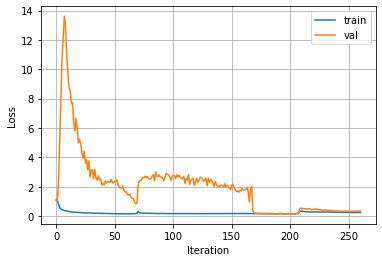

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 262/500, Loss: 0.2556781768798828 - Val. loss: 0.3556551933288574
Iteration 263/500, Loss: 0.25099802017211914 - Val. loss: 0.34371277689933777
Iteration 264/500, Loss: 0.26502057909965515 - Val. loss: 0.36155158281326294
Iteration 265/500, Loss: 0.2836878001689911 - Val. loss: 0.38313743472099304
Iteration 266/500, Loss: 0.3052513599395752 - Val. loss: 0.3910934627056122
Iteration 267/500, Loss: 0.3023017644882202 - Val. loss: 0.38743022084236145
Iteration 268/500, Loss: 0.30404675006866455 - Val. loss: 0.3926943242549896
Iteration 269/500, Loss: 0.29884621500968933 - Val. loss: 0.37443438172340393
Iteration 270/500, Loss: 0.30336350202560425 - Val. loss: 0.3883310556411743
Iteration 271/500, Loss: 0.28925761580467224 - Val. loss: 0.38919657468795776
Iteration 272/500, Loss: 0.29163679480552673 - Val. loss: 0.38613373041152954
Iteration 273/500, Loss: 0.2906719744205475 - Val. loss: 0.3880995810031891
Iteration 274/500, Loss: 0.28697729110717773 - Val. loss: 0.38481709361076

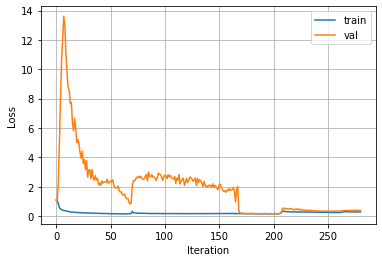

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 282/500, Loss: 0.28154563903808594 - Val. loss: 0.3865896165370941
Iteration 283/500, Loss: 0.28029000759124756 - Val. loss: 0.3870058059692383
Iteration 284/500, Loss: 0.2824212610721588 - Val. loss: 0.3876652121543884
Iteration 285/500, Loss: 0.27577826380729675 - Val. loss: 0.3874143660068512
Iteration 286/500, Loss: 0.2833912670612335 - Val. loss: 0.390286386013031
Iteration 287/500, Loss: 0.28490498661994934 - Val. loss: 0.3862983286380768
Iteration 288/500, Loss: 0.28239700198173523 - Val. loss: 0.38695207238197327
Iteration 289/500, Loss: 0.27796557545661926 - Val. loss: 0.3885831832885742
Iteration 290/500, Loss: 0.28208425641059875 - Val. loss: 0.3919895887374878
Iteration 291/500, Loss: 0.28266316652297974 - Val. loss: 0.3903820514678955
Iteration 292/500, Loss: 0.2818314731121063 - Val. loss: 0.38946935534477234
Iteration 293/500, Loss: 0.28078457713127136 - Val. loss: 0.39144372940063477
Iteration 294/500, Loss: 0.2833862900733948 - Val. loss: 0.38874250650405884


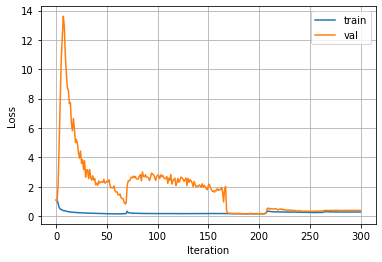

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 302/500, Loss: 0.27835655212402344 - Val. loss: 0.3880959749221802
Iteration 303/500, Loss: 0.28320908546447754 - Val. loss: 0.38680708408355713
Iteration 304/500, Loss: 0.2831622064113617 - Val. loss: 0.3900426924228668
Iteration 305/500, Loss: 0.27711233496665955 - Val. loss: 0.3907390534877777
Epoch   305: reducing learning rate of group 0 to 1.0000e-06.
Iteration 306/500, Loss: 0.2780822217464447 - Val. loss: 0.39325347542762756
Iteration 307/500, Loss: 0.2831159830093384 - Val. loss: 0.3928823471069336
Iteration 308/500, Loss: 0.28286585211753845 - Val. loss: 0.3924722373485565
Iteration 309/500, Loss: 0.2793724834918976 - Val. loss: 0.3926648199558258
Iteration 310/500, Loss: 0.27834799885749817 - Val. loss: 0.392607182264328
Iteration 311/500, Loss: 0.2779693305492401 - Val. loss: 0.39265045523643494
Iteration 312/500, Loss: 0.28239813446998596 - Val. loss: 0.3918924033641815
Iteration 313/500, Loss: 0.2787418067455292 - Val. loss: 0.39151135087013245
Iteration 314/500

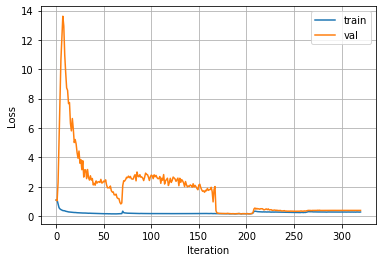

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 322/500, Loss: 0.273835688829422 - Val. loss: 0.3911859691143036
Iteration 323/500, Loss: 0.279207706451416 - Val. loss: 0.39094629883766174
Iteration 324/500, Loss: 0.2815720736980438 - Val. loss: 0.3909907042980194
Iteration 325/500, Loss: 0.2777269780635834 - Val. loss: 0.39132159948349
Iteration 326/500, Loss: 0.2797348201274872 - Val. loss: 0.39156198501586914
Iteration 327/500, Loss: 0.27470797300338745 - Val. loss: 0.39158639311790466
Iteration 328/500, Loss: 0.28263574838638306 - Val. loss: 0.3914448618888855
Iteration 329/500, Loss: 0.2794216573238373 - Val. loss: 0.39141368865966797
Iteration 330/500, Loss: 0.2804983854293823 - Val. loss: 0.3918519616127014
Iteration 331/500, Loss: 0.27835121750831604 - Val. loss: 0.3914155662059784
Iteration 332/500, Loss: 0.2749790847301483 - Val. loss: 0.39128243923187256
Iteration 333/500, Loss: 0.28421154618263245 - Val. loss: 0.3912544846534729
Iteration 334/500, Loss: 0.28084930777549744 - Val. loss: 0.3912670910358429
Iterat

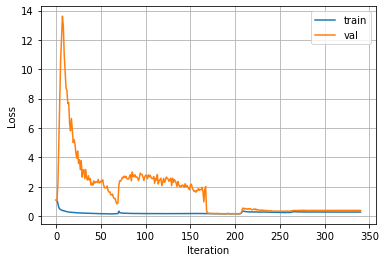

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 342/500, Loss: 0.27761727571487427 - Val. loss: 0.39174991846084595
Iteration 343/500, Loss: 0.28122806549072266 - Val. loss: 0.39236176013946533
Iteration 344/500, Loss: 0.27773424983024597 - Val. loss: 0.39186540246009827
Iteration 345/500, Loss: 0.27847838401794434 - Val. loss: 0.39175212383270264
Iteration 346/500, Loss: 0.2766532599925995 - Val. loss: 0.39264506101608276
Iteration 347/500, Loss: 0.2805423140525818 - Val. loss: 0.391879677772522
Iteration 348/500, Loss: 0.28110066056251526 - Val. loss: 0.39183828234672546
Iteration 349/500, Loss: 0.27404582500457764 - Val. loss: 0.3919525742530823
Iteration 350/500, Loss: 0.2813396453857422 - Val. loss: 0.3918359577655792
Iteration 351/500, Loss: 0.27274712920188904 - Val. loss: 0.3929014801979065
Iteration 352/500, Loss: 0.27818650007247925 - Val. loss: 0.3922724425792694
Iteration 353/500, Loss: 0.2825908660888672 - Val. loss: 0.39183372259140015
Iteration 354/500, Loss: 0.27690833806991577 - Val. loss: 0.39251312613487

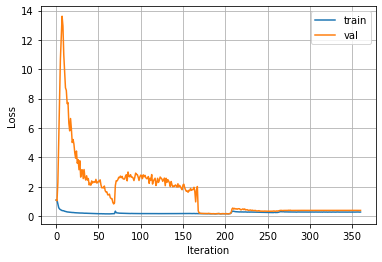

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 362/500, Loss: 0.2776646316051483 - Val. loss: 0.3917039632797241
Iteration 363/500, Loss: 0.2796470820903778 - Val. loss: 0.3916381001472473
Iteration 364/500, Loss: 0.27576732635498047 - Val. loss: 0.3915114998817444
Iteration 365/500, Loss: 0.2799898386001587 - Val. loss: 0.3913748860359192
Iteration 366/500, Loss: 0.2773813307285309 - Val. loss: 0.3911972641944885
Iteration 367/500, Loss: 0.27497756481170654 - Val. loss: 0.3911690413951874
Iteration 368/500, Loss: 0.27944299578666687 - Val. loss: 0.391708105802536
Iteration 369/500, Loss: 0.27874884009361267 - Val. loss: 0.3917725384235382
Iteration 370/500, Loss: 0.28008905053138733 - Val. loss: 0.39145931601524353
Iteration 371/500, Loss: 0.28252658247947693 - Val. loss: 0.3917348086833954
Iteration 372/500, Loss: 0.2824235260486603 - Val. loss: 0.3917403221130371
Iteration 373/500, Loss: 0.2815007269382477 - Val. loss: 0.39170897006988525
Iteration 374/500, Loss: 0.2762562930583954 - Val. loss: 0.3915763199329376
Itera

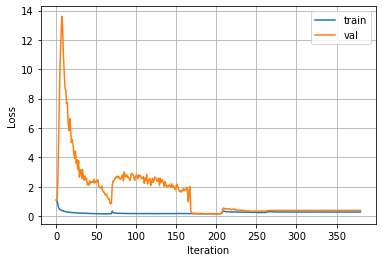

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 382/500, Loss: 0.2810438871383667 - Val. loss: 0.3920038640499115
Iteration 383/500, Loss: 0.2763224244117737 - Val. loss: 0.3915542960166931
Iteration 384/500, Loss: 0.2771356999874115 - Val. loss: 0.39218011498451233
Iteration 385/500, Loss: 0.28180181980133057 - Val. loss: 0.3919489085674286
Iteration 386/500, Loss: 0.281134694814682 - Val. loss: 0.3920476734638214
Iteration 387/500, Loss: 0.2801206409931183 - Val. loss: 0.3918725550174713
Iteration 388/500, Loss: 0.27625739574432373 - Val. loss: 0.3923918306827545
Iteration 389/500, Loss: 0.2738010585308075 - Val. loss: 0.3922765254974365
Iteration 390/500, Loss: 0.27827826142311096 - Val. loss: 0.3921477496623993
Iteration 391/500, Loss: 0.27905064821243286 - Val. loss: 0.39228054881095886
Iteration 392/500, Loss: 0.2820177674293518 - Val. loss: 0.39229318499565125
Iteration 393/500, Loss: 0.27915868163108826 - Val. loss: 0.3917030096054077
Iteration 394/500, Loss: 0.2820413410663605 - Val. loss: 0.3912818133831024
Itera

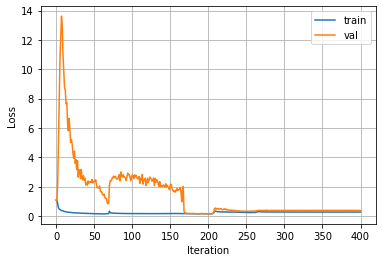

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 402/500, Loss: 0.27843156456947327 - Val. loss: 0.3920885920524597
Iteration 403/500, Loss: 0.280161052942276 - Val. loss: 0.3917136788368225
Iteration 404/500, Loss: 0.27594730257987976 - Val. loss: 0.39172789454460144
Iteration 405/500, Loss: 0.2771906852722168 - Val. loss: 0.39189252257347107
Iteration 406/500, Loss: 0.27413198351860046 - Val. loss: 0.39238908886909485
Iteration 407/500, Loss: 0.27932533621788025 - Val. loss: 0.3924471437931061
Iteration 408/500, Loss: 0.275749534368515 - Val. loss: 0.3931860327720642
Iteration 409/500, Loss: 0.27628639340400696 - Val. loss: 0.39262568950653076
Iteration 410/500, Loss: 0.27462953329086304 - Val. loss: 0.3927217721939087
Iteration 411/500, Loss: 0.28260132670402527 - Val. loss: 0.39243149757385254
Iteration 412/500, Loss: 0.27534472942352295 - Val. loss: 0.3927256762981415
Iteration 413/500, Loss: 0.2755737900733948 - Val. loss: 0.39256078004837036
Iteration 414/500, Loss: 0.2787284553050995 - Val. loss: 0.3925771713256836


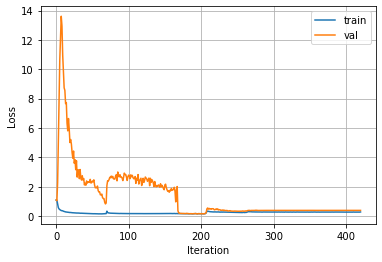

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 422/500, Loss: 0.28031718730926514 - Val. loss: 0.39228978753089905
Iteration 423/500, Loss: 0.2826744019985199 - Val. loss: 0.3925257623195648
Iteration 424/500, Loss: 0.2745206654071808 - Val. loss: 0.39264190196990967
Iteration 425/500, Loss: 0.277450829744339 - Val. loss: 0.3928038775920868
Iteration 426/500, Loss: 0.27563437819480896 - Val. loss: 0.39290809631347656
Iteration 427/500, Loss: 0.28071343898773193 - Val. loss: 0.3924880921840668
Iteration 428/500, Loss: 0.2788374423980713 - Val. loss: 0.3930058777332306
Iteration 429/500, Loss: 0.27943259477615356 - Val. loss: 0.39328521490097046
Iteration 430/500, Loss: 0.2809407114982605 - Val. loss: 0.3933676779270172
Iteration 431/500, Loss: 0.2795179784297943 - Val. loss: 0.3930627703666687
Iteration 432/500, Loss: 0.2750961184501648 - Val. loss: 0.39317262172698975
Iteration 433/500, Loss: 0.2791793644428253 - Val. loss: 0.3931058645248413
Iteration 434/500, Loss: 0.27981388568878174 - Val. loss: 0.393099308013916
Iter

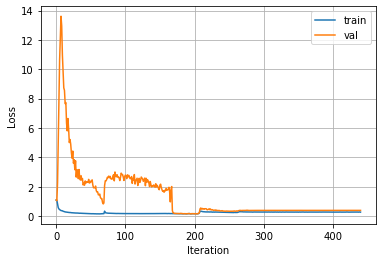

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 442/500, Loss: 0.2747173011302948 - Val. loss: 0.3926631510257721
Iteration 443/500, Loss: 0.2802482843399048 - Val. loss: 0.39324837923049927
Iteration 444/500, Loss: 0.2782970368862152 - Val. loss: 0.39301326870918274
Iteration 445/500, Loss: 0.27862048149108887 - Val. loss: 0.3924253284931183
Iteration 446/500, Loss: 0.273229718208313 - Val. loss: 0.39298027753829956
Iteration 447/500, Loss: 0.2727294862270355 - Val. loss: 0.3936065137386322
Iteration 448/500, Loss: 0.279482901096344 - Val. loss: 0.39382877945899963
Iteration 449/500, Loss: 0.27379515767097473 - Val. loss: 0.3937942385673523
Iteration 450/500, Loss: 0.27888232469558716 - Val. loss: 0.3934236764907837
Iteration 451/500, Loss: 0.28116315603256226 - Val. loss: 0.3934820592403412
Iteration 452/500, Loss: 0.2730819582939148 - Val. loss: 0.39322903752326965
Iteration 453/500, Loss: 0.28139588236808777 - Val. loss: 0.3935278654098511
Iteration 454/500, Loss: 0.27871134877204895 - Val. loss: 0.3927710950374603
Ite

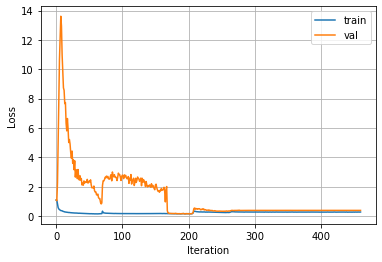

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 462/500, Loss: 0.2742590308189392 - Val. loss: 0.392121285200119
Iteration 463/500, Loss: 0.2725953757762909 - Val. loss: 0.39238375425338745
Iteration 464/500, Loss: 0.27792245149612427 - Val. loss: 0.3928327262401581
Iteration 465/500, Loss: 0.27485325932502747 - Val. loss: 0.3924967050552368
Iteration 466/500, Loss: 0.27908870577812195 - Val. loss: 0.3923649191856384
Iteration 467/500, Loss: 0.2774103581905365 - Val. loss: 0.3921676278114319
Iteration 468/500, Loss: 0.28321611881256104 - Val. loss: 0.39216190576553345
Iteration 469/500, Loss: 0.2786022126674652 - Val. loss: 0.391864538192749
Iteration 470/500, Loss: 0.28193140029907227 - Val. loss: 0.3921050429344177
Iteration 471/500, Loss: 0.2781091332435608 - Val. loss: 0.3918294310569763
Iteration 472/500, Loss: 0.27601537108421326 - Val. loss: 0.39228007197380066
Iteration 473/500, Loss: 0.27763161063194275 - Val. loss: 0.39227089285850525
Iteration 474/500, Loss: 0.2741762101650238 - Val. loss: 0.3920992910861969
Ite

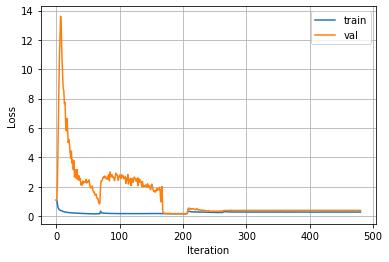

c:\Users\s126005\Anaconda3\envs\pytorch191_py37\lib\site-packages\torch\optim\lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Iteration 482/500, Loss: 0.28139951825141907 - Val. loss: 0.39267125725746155
Iteration 483/500, Loss: 0.27437809109687805 - Val. loss: 0.3927358388900757
Iteration 484/500, Loss: 0.2790704369544983 - Val. loss: 0.39288803935050964
Iteration 485/500, Loss: 0.27593475580215454 - Val. loss: 0.3925383687019348
Iteration 486/500, Loss: 0.27176547050476074 - Val. loss: 0.39275047183036804
Iteration 487/500, Loss: 0.27848437428474426 - Val. loss: 0.3925425410270691
Iteration 488/500, Loss: 0.27792662382125854 - Val. loss: 0.39355066418647766
Iteration 489/500, Loss: 0.281596302986145 - Val. loss: 0.39325547218322754
Iteration 490/500, Loss: 0.27048811316490173 - Val. loss: 0.39302971959114075
Iteration 491/500, Loss: 0.2777625322341919 - Val. loss: 0.3922847509384155
Iteration 492/500, Loss: 0.27065178751945496 - Val. loss: 0.39287349581718445
Iteration 493/500, Loss: 0.276334673166275 - Val. loss: 0.39308232069015503
Iteration 494/500, Loss: 0.2758263051509857 - Val. loss: 0.393165767192840

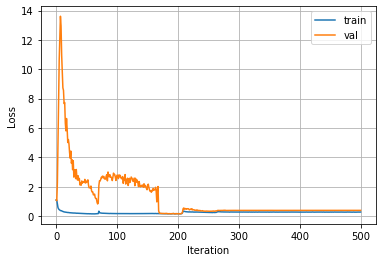

In [22]:
# Define the model
model = Model(hypernet_settings=settings['hypernet_settings'],
                encoder_settings=settings['encoder_settings'],
                sampling_type=settings['sampling_type'],
                nr_classes=settings['nr_classes'])

model.to(device)

# Define optimizer and lr scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, verbose=True, min_lr=1e-6)

# Create dataloaders for the train and validation sets
data_loaders = []
for data_fold in ['train', 'val']:
    data_set = synthetic_dataset(data_fold=data_fold, channels=['ch0','ch1'], nr_classes=nr_classes)
    data_loaders.append(DataLoader(data_set,
                                    batch_size=128,
                                    shuffle= True if data_fold == 'train' else False,
                                    drop_last=False,
                                    pin_memory=True,
                                    num_workers= 0))
data_loader_train, data_loader_val = data_loaders

# Training loop
all_losses = {'train':[], 'val':[]}
best_val_loss = np.inf

for i in range(nr_iters):
    total_loss_train = []
    model.train()
    for x_train, y_train in data_loader_train:
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # Zero the gradients
        model.zero_grad()

        # Forward pass
        y_hat_train,_ = model(x_train, i)
        loss =  F.nll_loss(y_hat_train, y_train)
        total_loss_train.append(loss.clone().to('cpu').detach().numpy())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    total_loss_val = []
    with torch.no_grad():
        for x_val, y_val in data_loader_val:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_hat_val,_ = model(x_val, i)
            loss_val =  F.nll_loss(y_hat_val, y_val)
            total_loss_val.append(loss_val.clone().to('cpu').detach().numpy())
    
    if i > (nr_iters//2-1):     
        scheduler.step(metrics=loss_val, epoch=i) 

    all_losses['train'].append(np.mean(total_loss_train))
    all_losses['val'].append(np.mean(total_loss_val))
    print(f"Iteration {i+1}/{nr_iters}, Loss: {all_losses['train'][-1]} - Val. loss: {all_losses['val'][-1]}")

    if all_losses['val'][-1] < best_val_loss:
        best_val_loss = all_losses['val'][-1]
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'Stored a new best model at iteration {i+1}.' )

    if (i > 0 and i % 20 == 0) or (i == nr_iters-1):    
        # The validation loss first increases, while the train loss decreases due to 
        # the fact that during training soft samples are used, which are annealed to hard samples via the GS temperature parameter.
        plt.plot(all_losses['train'], label='train')
        plt.plot(all_losses['val'], label='val')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


### Evaluate the model

As can be seen in the training graphs, the validation loss first increases, while the training loss already decreases. 
This is caused by the fact that we use soft-sampling during training, while already evaluating the validation set using hard samples.
Towards the end of training, both losses converge to a similar value, as we anneal the Gumbel-Softmax temperature to a lower value.

Let's evaluate the F1 scores for classification (as provided in Table 1 of the paper).

In [23]:
from sklearn.metrics import f1_score

# Load the best model
model = Model(hypernet_settings=settings['hypernet_settings'],
                encoder_settings=settings['encoder_settings'],
                sampling_type=settings['sampling_type'],
                nr_classes=settings['nr_classes'])

model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

# Evaluate the model on the test dataset
data_set_test = synthetic_dataset(data_fold='test', channels=['ch0','ch1'], nr_classes=nr_classes)
data_loader_test = DataLoader(data_set_test,
                    batch_size=128,
                    shuffle= False,
                    drop_last=False,
                    pin_memory=True,
                    num_workers= 0)


total_loss_test = []
all_y_test, all_y_hat_test = [], []
with torch.no_grad():
    for x_test, y_test in data_loader_test:
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        y_hat_test, _ = model(x_test)
        loss_test = F.nll_loss(y_hat_test, y_test)
        total_loss_test.append(loss_test.clone().to('cpu').detach().numpy())

        all_y_test.extend(y_test.clone().to('cpu').detach().numpy())
        all_y_hat_test.extend(y_hat_test.clone().to('cpu').detach().numpy())

print(f"Test loss: {np.mean(total_loss_test):.2f}")

f1_scores = np.array(f1_score(all_y_test, np.stack(all_y_hat_test,0).argmax(1), average=None, labels=[0,1,2]))*100
print(f'F1 scores per class: {f1_scores}')
print(f'Avg. F1 score: {np.mean(f1_scores):.2f}')


Test loss: 0.16
F1 scores per class: [93.2345679  96.47417572 96.07666966]
Avg. F1 score: 95.26


### Plot part of a test subject's data and the selected mini-windows in green

In [24]:
subject = 's150' # the test set contains subjects between s150 and s199

xtest, ytest = data_set_test.get_subject(subject)
xtest = torch.as_tensor(xtest, device=device)
ytest = torch.as_tensor(ytest, device=device)

with torch.no_grad():    
    x_test_chunked = torch.stack(torch.chunk(xtest, xtest.shape[-1] // window_length, dim=1),0) #[nr windows, channels, window_length]
    y_hat_subject, selection_matrix = model(x_test_chunked) #[nr windows, nr_classes], [nr windows, k, nr mini windows in a window]

y_hat_subject = y_hat_subject.clone().to('cpu').detach().numpy()
selection_matrix = selection_matrix.clone().to('cpu').detach().numpy()

# Convert the selection matrix of size [nr windows , k , N] to a binary sampling mask of shape [nr windows, nr channels, nr mini-windows per window]
selection_mask = selection_matrix.reshape((-1,k,nr_channels,settings['hypernet_settings']['mini_window_temporal_reduction_factor'])).sum(1)


Text(0.5, 1.3, 'Selected mini-windows in green\nSubject: s150 @0sec')

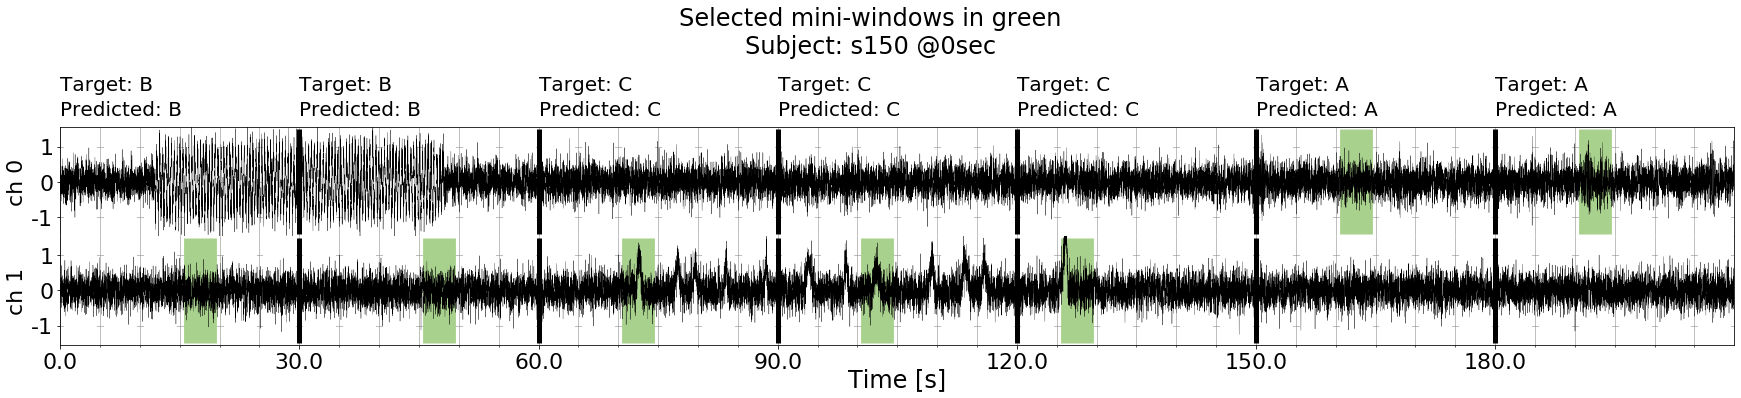

In [25]:
from matplotlib.colors import ListedColormap

### Indicate which window indices to plot
window_idx_start, window_idx_end = 0, 7
###

fs = data_set_test.fs #sampling frequency
raw_data = x_test_chunked.clone().to('cpu').detach().numpy()

start_sec, end_sec = window_idx_start*30, window_idx_end*30
start_sample, end_sample = start_sec*fs, end_sec*fs
time_axis = np.arange(start_sample, end_sample)


fig, axs = plt.subplots(2, 1, figsize=(30,4), sharex=True)
plt.subplots_adjust(hspace=0.)


ch_list = ['ch0', 'ch1']
ymin, ymax = -1, 1
for ch_idx, ch in enumerate(ch_list):

    # Plot the feature masks for both channels in the same plots where the data is also plotted, and indicate the selected mini-windows in green
    # white-green cmap for selected windows
    color0 = '#FFFFFF'  # White
    color1 = '#A9D18E'  # Green
    cmap_windows = ListedColormap([color0, color1])
    im = axs[ch_idx].vlines(np.arange(start_sample+2.5*fs,end_sample+2.5*fs,5*fs), ymin=-1.5, ymax=1.5, colors=cmap_windows(selection_mask[window_idx_start:window_idx_end,ch_idx].flatten()), linewidth=6900/(end_sec-start_sec), alpha=1)

    # Plot the data streams on top
    axs[ch_idx].plot(time_axis, raw_data[window_idx_start:window_idx_end,ch_idx].flatten(), 'k', linewidth=0.3) 
    axs[ch_idx].set_xticks(np.arange(start_sample, end_sample, 5*fs), minor=True) # minor ticks at 5s mini-windows
    axs[ch_idx].set_xticks(np.arange(start_sample, end_sample, 30*fs))
    axs[ch_idx].set_xticklabels(np.arange(0, end_sample-start_sample, 30*fs)/fs, fontsize=22)
    
    ymin, ymax = -1.5,1.5
    axs[ch_idx].set_ylim([ymin-0.05, ymax+0.05])
    axs[ch_idx].set_yticks([-1, 0, 1])
    axs[ch_idx].set_yticklabels(labels=[-1, 0, 1],fontsize=22)
        
    # Set grid lines
    axs[ch_idx].grid(True, which='both', linestyle='-', linewidth='0.5', color='gray', axis='x')
    axs[ch_idx].grid(True, which='major', linestyle='-', linewidth='0.5', color='gray', axis='y')

    # Plot a line at 30-second window boundaries
    axs[ch_idx].vlines(np.arange(start_sample+3000, end_sample, 30*fs), ymin=ymin, ymax=ymax, colors='k', linewidth=5, zorder=10)
    axs[ch_idx].set_ylabel(f'ch {ch_idx}',fontsize=22)
    axs[ch_idx].margins(x=0)


axs[ch_idx].set_xlabel('Time [s]',fontsize=24, labelpad=-5)

conv_label = {0:'A', 1:'B', 2:'C'}
preds = np.argmax(y_hat_subject,-1)[window_idx_start:window_idx_end]
targets = ytest[window_idx_start:window_idx_end].clone().to('cpu').detach().numpy()
for i, (y_hat, y) in enumerate(zip(preds, targets)):
    plt.text(time_axis[i*3000],5.7, f'Target: {conv_label[y]}', fontsize=20)
    plt.text(time_axis[i*3000],5.0, f'Predicted: {conv_label[y_hat]}',fontsize=20)

axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.suptitle(f'Selected mini-windows in green\nSubject: {subject} @{start_sec}sec', y=1.3, fontsize=24)